In [1]:
import pandas as pd
import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 18})
import seaborn as sns
import regex as re
import os
import numpy as np
from ast import literal_eval

In [9]:
plt.rcParams.update({'font.size': 16})

In [ ]:
! cd ../results && pwd && find ~+ -type f -name "parameters.txt"

In [3]:
result_paths = {
    '0.85': "/mnt/extra/continuous-training/results/1718054966687080958/",
    '0.9': "/mnt/extra/continuous-training/results/1718046192027299457/",
    '0.95': "/mnt/extra/continuous-training/results/1718057978522183745/",
    '0.99': "/mnt/extra/continuous-training/results/1718059741712305101/",
}

In [4]:
stats_df = pd.DataFrame(columns=['folder_path', 'algo', 'threshold', 'param_path', 'csv_path', 'latencies_path', 'num_retrain', 'training_time_total', 'training_time_single', 'training_cpu_time', 'training_counter', 'inference_time_total', 'inference_time_single', 'inference_cpu_time', 'inference_counter'])

for key, stat in result_paths.items():
    contents = []
    with open(os.path.join(stat, 'parameters.txt'), "r") as f:
        contents = f.readlines()
    # Iterate to get variables
    folder_path = stat
    algo_name = 'nurd'
    csv_path = os.path.join(folder_path, 'nurd')
    latencies_path = os.path.join(folder_path, 'latencies.csv')
    param_path = stat
    valid_entry = False
    retrained = -1
    training_time_total = -1
    training_time_single = -1
    training_cpu_time = -1
    training_counter = -1
    inference_time_total = -1
    inference_time_single = -1
    inference_cpu_time = -1
    inference_counter = -1
    for content in contents:
        if not valid_entry and 'Inference' in content:
            valid_entry = True
        if 'Retrained' in content:
            retrained = float(content.split(' = ')[1].split('\n')[0])
        if 'Training time total' in content:
            training_time_total = float(content.split(' = ')[1].split(' s')[0])
        if 'Training time single' in content:
            training_time_single = float(content.split(' = ')[1].split(' s')[0])
        if 'Training CPU times usage' in content:
            training_cpu_time = float(content.split(' = ')[1].split(' sCPU')[0])
        if 'Training counter' in content:
            training_counter = float(content.split(' = ')[1].split('\n')[0])
        if 'Inference time total' in content:
            inference_time_total = float(content.split(' = ')[1].split(' s')[0])
        if 'Inference time single' in content:
            inference_time_single = float(content.split(' = ')[1].split(' s')[0])
        if 'Inference CPU times usage' in content:
            inference_cpu_time = float(content.split(' = ')[1].split(' sCPU')[0])
        if 'Inference counter' in content:
            inference_counter = float(content.split(' = ')[1].split('\n')[0])
    if valid_entry:
        stats_df.loc[len(stats_df)] = [folder_path, algo_name, key, param_path, csv_path, latencies_path, retrained, training_time_total, training_time_single, training_cpu_time, training_counter, inference_time_total, inference_time_single, inference_cpu_time, inference_counter]
stats_df

,folder_path,algo,threshold,param_path,csv_path,latencies_path,num_retrain,training_time_total,training_time_single,training_cpu_time,training_counter,inference_time_total,inference_time_single,inference_cpu_time,inference_counter
0,/mnt/extra/continuous-training/results/1718054...,nurd,0.85,/mnt/extra/continuous-training/results/1718054...,/mnt/extra/continuous-training/results/1718054...,/mnt/extra/continuous-training/results/1718054...,-1,2081.151994,2081.151994,9485.74,1.0,48.461719,0.000002,136.52,28686125.0
1,/mnt/extra/continuous-training/results/1718046...,nurd,0.9,/mnt/extra/continuous-training/results/1718046...,/mnt/extra/continuous-training/results/1718046...,/mnt/extra/continuous-training/results/1718046...,-1,1763.596897,1763.596897,6704.09,1.0,47.902467,0.000002,135.59,28686125.0
2,/mnt/extra/continuous-training/results/1718057...,nurd,0.95,/mnt/extra/continuous-training/results/1718057...,/mnt/extra/continuous-training/results/1718057...,/mnt/extra/continuous-training/results/1718057...,-1,1571.938790,1571.938790,9326.29,1.0,54.738735,0.000002,351.66,28686125.0
3,/mnt/extra/continuous-training/results/1718059...,nurd,0.99,/mnt/extra/continuous-training/results/1718059...,/mnt/extra/continuous-training/results/1718059...,/mnt/extra/continuous-training/results/1718059...,-1,1305.981088,1305.981088,7658.64,1.0,52.676285,0.000002,269.72,28686125.0


In [5]:
values_df = pd.DataFrame({
    'threshold': pd.Series(dtype='int'),
    'path': pd.Series(dtype='string'),
    'algo': pd.Series(dtype='string'),
    'length': pd.Series(dtype='int'),
    'f1': pd.Series(dtype='object'),
    'roc_auc': pd.Series(dtype='object'),
    'latencies_acc': pd.Series(dtype='object'),
    'latencies_rej': pd.Series(dtype='object'),
    'retrain': pd.Series(dtype='int'),
    'training_time_total': pd.Series(dtype='float'),
    'training_time_single': pd.Series(dtype='float'),
    'training_cpu_time': pd.Series(dtype='float'),
    'training_counter': pd.Series(dtype='int'),
    'inference_time_total': pd.Series(dtype='float'),
    'inference_time_single': pd.Series(dtype='float'),
    'inference_cpu_time': pd.Series(dtype='float'),
    'inference_counter': pd.Series(dtype='int'),
})

for i, row in stats_df.iterrows():
    temp_df = pd.read_csv(os.path.join(row['folder_path'], row['csv_path']), index_col=0)
    temp_df = temp_df.drop_duplicates(subset='minute', keep="last")
    retrain_list = temp_df['retrain'].tolist()
    retrain = [i for i in retrain_list if i==True]
    latencies_df = pd.read_csv(row['latencies_path'], header=None, names=['latency', 'reject'], dtype={'latency': int, 'reject': str})
    latencies_acc = latencies_df[latencies_df['reject'].isin(["0", "True"])]['latency'].tolist()
    latencies_rej = latencies_df[latencies_df['reject'].isin(["1", "False"])]['latency'].tolist()
    # if temp_df['minute'].max() == 480:
    # if i != 3:
    #     values_df.loc[len(values_df)] = [row['folder_path'], row['algo'], temp_df['minute'].max(), temp_df['f1_score'].tolist()[:-5], temp_df['roc_auc'].tolist()[:-5], row['num_retrain'], row['training_time_total'], row['training_time_single'], row['training_cpu_time'], row['training_counter'], row['inference_time_total'], row['inference_time_single'], row['inference_cpu_time'], row['inference_counter']]
    # else:
    values_df.loc[len(values_df)] = [row['threshold'], row['folder_path'], row['algo'], temp_df['minute'].max(), temp_df['f1_score'].tolist(), temp_df['roc_auc'].tolist(), latencies_acc, latencies_rej, row['num_retrain'], row['training_time_total'], row['training_time_single'], row['training_cpu_time'], row['training_counter'], row['inference_time_total'], row['inference_time_single'], row['inference_cpu_time'], row['inference_counter']]

# print(values_df.iloc[13]['path'])
# values_df.drop([13], inplace=True)
values_df.reset_index(inplace=True, drop=True)
# values_df.to_csv('values_all_minmax.csv')
values_df

,threshold,path,algo,length,f1,roc_auc,latencies_acc,latencies_rej,retrain,training_time_total,training_time_single,training_cpu_time,training_counter,inference_time_total,inference_time_single,inference_cpu_time,inference_counter
0,0.85,/mnt/extra/continuous-training/results/1718054...,nurd,30,"[0.4825877936149784, 0.4773631075843672, 0.469...","[0.4755154487946451, 0.4774560817066086, 0.480...","[122, 117, 392, 335, 220, 776, 389, 508, 485, ...","[199, 699, 263, 390, 273, 247, 210, 767, 697, ...",-1,2081.151994,2081.151994,9485.74,1.0,48.461719,0.000002,136.52,28686125.0
1,0.9,/mnt/extra/continuous-training/results/1718046...,nurd,30,"[0.0681294816331881, 0.0721231443658463, 0.066...","[0.513556243375378, 0.5144231004570112, 0.5134...","[122, 199, 699, 117, 392, 263, 335, 390, 273, ...","[767, 250, 233, 354, 416, 142, 677, 210, 91, 7...",-1,1763.596897,1763.596897,6704.09,1.0,47.902467,0.000002,135.59,28686125.0
2,0.95,/mnt/extra/continuous-training/results/1718057...,nurd,30,"[0.0, 0.0, 0.0, 0.0, 2.803126607417914e-06, 2....","[0.5, 0.5, 0.5, 0.5, 0.500000700782634, 0.5000...","[122, 199, 699, 117, 392, 263, 335, 390, 273, ...","[1205, 1571, 2029, 1053, 90, 1832, 3468, 835, ...",-1,1571.938790,1571.938790,9326.29,1.0,54.738735,0.000002,351.66,28686125.0
3,0.99,/mnt/extra/continuous-training/results/1718059...,nurd,30,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, ...","[122, 199, 699, 117, 392, 263, 335, 390, 273, ...",[],-1,1305.981088,1305.981088,7658.64,1.0,52.676285,0.000002,269.72,28686125.0


30
30
30
30


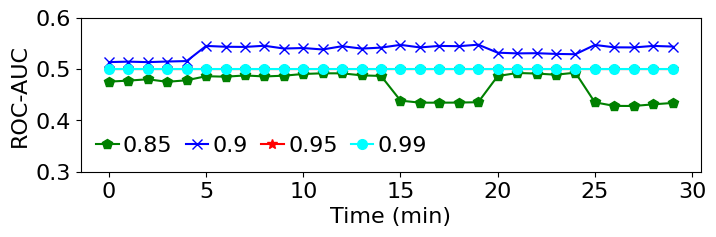

In [12]:
df_plot = values_df.copy(deep=True)
df_plot['id'] = df_plot['threshold']

plot_df = pd.DataFrame(columns=df_plot['threshold'].tolist())
f1s = df_plot['roc_auc'].tolist()
for f1 in f1s:
    print(len(f1))
for i in range(0, 30):
    plot_df.loc[len(plot_df)] = [f1s[0][i], f1s[1][i], f1s[2][i], f1s[3][i]]

fig, ax = plt.subplots(figsize=(8, 2))

colors = ['green', 'blue', 'red', 'cyan']
markers = ['p', 'x', '*', 'o']

for idx, col in enumerate(plot_df.columns):
    plt.plot(plot_df.index, plot_df[col], label=col, color=colors[idx], linewidth=1.5, marker=markers[idx], markersize=7)
plt.legend(ncol=5, loc="best",
           alignment='left', 
           frameon=False, facecolor=(1, 1, 1, 0), 
           edgecolor='black', labelspacing=0.25, columnspacing=0.6, borderpad=0.2, 
           handletextpad=0.2, handlelength=1)
plt.ylim(0.3, 0.6)
plt.xlabel('Time (min)')
plt.ylabel('ROC-AUC')
plt.show()

In [19]:
import numpy as np

def plot_cdf(latencies_acc, all_latencies):
    # Draw CDF
    N=len(latencies_acc)
    data = latencies_acc
    # sort the data in ascending order
    x_1 = np.sort(data)
    # get the cdf values of y
    y_1 = np.arange(N) / float(N)

    y_test = all_latencies
    N=len(y_test)
    data = y_test
    # sort the data in ascending order
    x_2 = np.sort(data)
    # get the cdf values of y
    y_2 = np.arange(N) / float(N)
    percent_slow = int( (N-len(data)) / N * 100)

    # plotting
    plt.figure(figsize=(4,3))
    plt.xlabel('Latency (us)')
    plt.ylabel('CDF')
    p70_lat = np.percentile(x_2, 70)
    plt.xlim(0, max(p70_lat * 3, 1000)) # Hopefully the x axis limit can catch the tail
    plt.ylim(0, 1) 
    plt.plot(x_2, y_2, label = "Raw Latency", color="red")
    plt.plot(x_1, y_1, label = "Model Reweight", linestyle='dashdot', color="green")
    plt.legend(loc="lower right")
    plt.show()

0.85


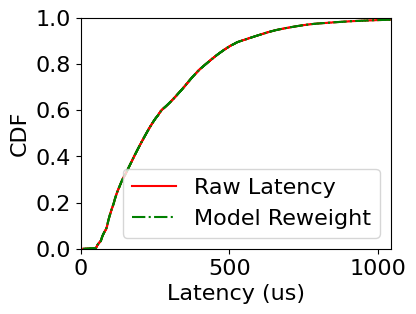

0.9


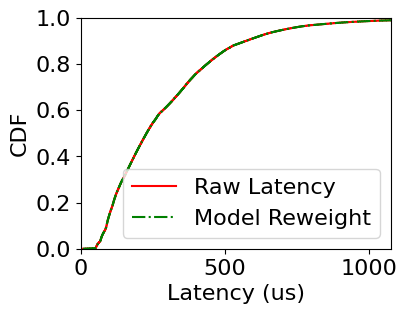

0.95


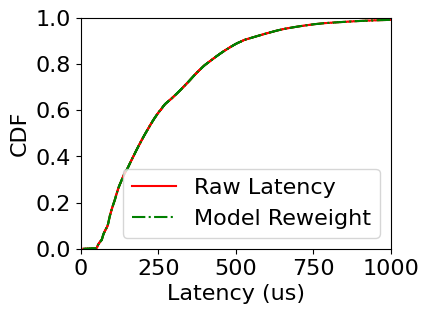

0.99


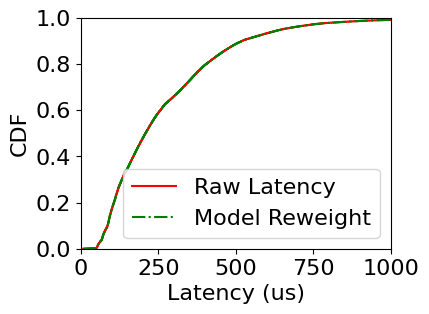

In [20]:
for i, row in values_df.iterrows():
    latencies_acc = row['latencies_acc']
    all_latencies = latencies_acc
    all_latencies.extend(row['latencies_rej'])

    print(row['threshold'])
    plot_cdf(latencies_acc, all_latencies)